## Laboratorium 14


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie nie będzie jednak centralne na laboratorium.

---

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

from time import sleep
from IPython.display import display, Image
from scipy.spatial import distance_matrix

In [2]:
def show_image(image, dpi=200):
    plt.figure(dpi=dpi)
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.axis("off");

In [3]:
def play_video(filename, delay=0.02, skip=0, duration=None, infinity=True, function=None):
    display_handle=display(None, display_id=True)
    try:
        while True:
            cache = {}
            video = cv2.VideoCapture(filename)
            prev_frame = None
            r, frame = video.read()
            
            for _ in range(skip):
                prev_frame = frame
                r, frame = video.read()
                
            num = 0
            
            while r:
                if function is not None and prev_frame is not None:
                    new_frame, cache = function(prev_frame[...,::-1], frame[...,::-1], cache)
                else:
                    new_frame = frame.copy()
                    
                prev_frame = frame
                
                _, new_frame_encoded = cv2.imencode('.jpeg', new_frame[...,::-1])
                display_handle.update(Image(data=new_frame_encoded.tobytes()))
                
                r, frame = video.read()
                
                num += 1
                
                if duration is not None and num >= duration:
                    break
                
                sleep(delay)
            
            if not infinity:
                break
            
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)
        
        return new_frame
        
        
# play_video('amsterdam47.mp4')

### Zadanie 1 (1.5 pkt | 1.0 pkt)

#### Zadanie 1a (1.5 pkt | 0.0 pkt)

Dany jest plik `amsterdam47.mp4` przedstawiający zapis ruchu na skrzyżowaniu. Uzupełnij podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii obiektów, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie znalezionych obiektów). Niekoniecznie musisz przetwarzać cały materiał wideo - zwróć uwagę, że pojazdy znikają poza klatką, uniemożliwiając ich dalsze śledzenie.

In [4]:
def flow(prev_image, next_image, cache):
    frame = next_image.copy()
    
    prev_image = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)
    next_image = cv2.cvtColor(next_image, cv2.COLOR_RGB2GRAY)

    if not cache:
        cache = dict(
            p0=cv2.goodFeaturesToTrack(
                prev_image,
                mask=None,
                maxCorners=100,
                qualityLevel=0.3,
                minDistance=7,
                blockSize=7,
            ),
            mask=np.zeros_like(frame),
            color=np.random.randint(0, 255, (100, 3)),
        )

    p0 = cache['p0']
    mask = cache['mask']
    color = cache['color']

    p1, st, err = cv2.calcOpticalFlowPyrLK(
        prevImg=prev_image,
        nextImg=next_image,
        prevPts=p0,
        nextPts=None,
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

    cache.update(dict(
        p0=good_new.reshape(-1, 1, 2),
        mask=mask,
    ))

    return cv2.add(frame, mask), cache

In [5]:
play_video('amsterdam47.mp4', function=flow);

None

#### Zadanie 1b (0.0 pkt | 1.0 pkt)

Powtórz poprzednie doświadczenie na różnych fragmentach materiału źródłowego. Kiedy i w jaki sposób metoda zawodzi?

None

None

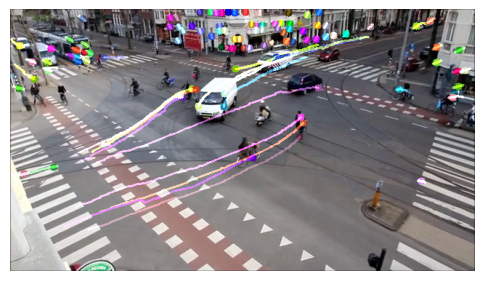

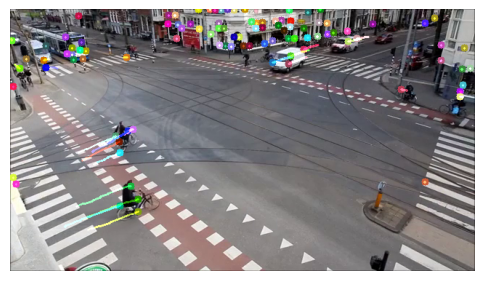

In [6]:
before = play_video('amsterdam47.mp4', function=flow, infinity=False, delay=0, duration=160)
after = play_video('amsterdam47.mp4', function=flow, infinity=False, delay=0, duration=240)
show_image(before, dpi=100)
show_image(after, dpi=100)

Komentarz 1:

Metoda zawodzi, gdy:
- Obiekty się pokryją i część punktów z jednego obiektu zostaje przypisana do drugiego jak w pokazanym przykładzie rower/ciężarówka – część punktów należących do roweru "powędrowała" za ciężarówką.
- Zmienia się wygląd obiektu/jego perspektywa, niektóre śledzone punkty mogą zostać "porzucone" i później przechwycone przez inny obiekt jak w przypadku dwóch różnych rowerów lub w momencie, gdy czarne auto wyjeżdżające z lewej strony zostawia punkt, który później zostaje zabrany przez skuter.
- Brak śledzenia nowych punktów (jednorazowa inicjalizajca punktów).

### Zadanie 2 (1.0 pkt | 0.0 pkt)

Wykorzystując historię położenia poszczególnych obiektów, zidentyfikuj punkty należące do tła i odfiltruj je ze zbioru śledzonych obiektów.  
*Jeśli starczy czasu:* zidentyfikuj punkty należące do tych samych obiektów (tj. poruszające się w ten sam sposób).

In [7]:
def flow_remove_no_moving_points(prev_image, next_image, cache):
    frame = next_image.copy()
    
    prev_image = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)
    next_image = cv2.cvtColor(next_image, cv2.COLOR_RGB2GRAY)

    if not cache:
        cache = dict(
            color=np.random.randint(0, 255, (100, 3)),
            points=[
            cv2.goodFeaturesToTrack(
                prev_image,
                mask=None,
                maxCorners=100,
                qualityLevel=0.3,
                minDistance=7,
                blockSize=7,
            ),
            ],
            point_mask=np.ones((100, 1), dtype=bool),
        )

    points = cache['points']
    p0 = points[-1]
    color = cache['color']
    point_mask = cache['point_mask']

    p1, st, err = cv2.calcOpticalFlowPyrLK(
        prevImg=prev_image,
        nextImg=next_image,
        prevPts=p0,
        nextPts=None,
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    
    if p1 is not None:
        point_mask = point_mask & (st == 1)
        
        points.append(p1)
    
        distances = []
        for i in range(max(0, len(points) - 20), len(points) - 1):
            distances.append(np.linalg.norm(points[i] - points[i + 1], axis=2))

        distances = np.mean(distances, axis=0)
        mean = distances.mean()
        mask = distances >= mean
        pt_mask = point_mask & mask
        indices = np.arange(len(point_mask))
        
        
        mask=np.zeros_like(frame)
        for j in range(len(points) - 1):
            idxs = indices[pt_mask.ravel()]
            olds = points[j][pt_mask]
            news = points[j + 1][pt_mask]
            for i, old, new in zip(idxs, olds, news):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
                if j + 2 == len(points):
                    frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
                    
        

        for i in range(len(points)):
            points[i] = points[i][point_mask.squeeze()]

        color = color[point_mask.squeeze()]
        point_mask = point_mask[point_mask.squeeze()]

    cache.update(dict(
        points=points,
        point_mask=point_mask,
        color=color,
    ))

    return cv2.add(frame, mask), cache

In [8]:
play_video('amsterdam47.mp4', function=flow_remove_no_moving_points);

None

#### Zadanie 3 (1.5 pkt | 0.0 pkt)

Rozszerz rozwiązanie z zadania 1 o możliwość śledzenia nowych obiektów pojawiających się w polu widzenia. Zadbaj o to, by ponowna detekcja punktów zainteresowania nie tworzyła duplikatów obiektów, które już są znane i śledzone.

In [9]:
def flow_new_points(prev_image, next_image, cache):
    frame = next_image.copy()
    
    prev_image = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)
    next_image = cv2.cvtColor(next_image, cv2.COLOR_RGB2GRAY)

    if not cache:
        cache = dict(
            color=np.random.randint(0, 255, (100, 3)),
            points=[
                cv2.goodFeaturesToTrack(
                    prev_image,
                    mask=None,
                    maxCorners=100,
                    qualityLevel=0.3,
                    minDistance=7,
                    blockSize=7,
                ),
            ],
            point_mask=np.ones((100, 1), dtype=bool),
            number=0,
        )
    number = cache['number']
    points = cache['points']
    color = cache['color']
    point_mask = cache['point_mask']
    p0 = points[-1]
    
    if number % 2 == 0:
        new_features = cv2.goodFeaturesToTrack(
                prev_image,
                mask=None,
                maxCorners=100,
                qualityLevel=0.3,
                minDistance=7,
                blockSize=7,
            )
        distances = distance_matrix(new_features.squeeze(1), p0.squeeze(1))
        mask = np.all(distances > 50, axis=1)
        new_features = new_features[mask]
        
        if len(new_features):
            for i in range(len(points)):
                points[i] = np.concatenate([points[i], new_features])

            color = np.concatenate([color, np.random.randint(0, 255, (len(new_features), 3))])
            point_mask = np.concatenate([point_mask, np.ones((len(new_features), 1), dtype=bool)])
        
        
    p0 = points[-1]

    p1, st, err = cv2.calcOpticalFlowPyrLK(
        prevImg=prev_image,
        nextImg=next_image,
        prevPts=p0,
        nextPts=None,
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    if p1 is not None:
        point_mask = point_mask & (st == 1)

        points.append(p1)

        distances = []
        for i in range(max(0, len(points) - 10), len(points) - 1):
            distances.append(np.linalg.norm(points[i] - points[i + 1], axis=2))

        distances = np.mean(distances, axis=0)
        mean = distances.mean()
        mask = distances >= mean / 4
        point_mask = point_mask & mask
        
        indices = np.arange(len(point_mask))

        mask=np.zeros_like(frame)
        for j in range(len(points) - 1):
            idxs = indices[point_mask.ravel()]
            olds = points[j][point_mask]
            news = points[j + 1][point_mask]
            for i, old, new in zip(idxs, olds, news):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
                if j + 2 == len(points):
                    frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)


        for i in range(len(points)):
            points[i] = points[i][point_mask.squeeze()]

        color = color[point_mask.squeeze()]
        point_mask = point_mask[point_mask.squeeze()]

    cache.update(dict(
        points=points,
        point_mask=point_mask,
        color=color,
        number=number+1
    ))

    return cv2.add(frame, mask), cache


play_video('amsterdam47.mp4', function=flow_new_points);

None